## 🚀 NOTEBOOK STARTS BELOW

In [73]:
# ============================================================
# 02_prophet_forecasting_industry_consumption.ipynb
# Forecasting India's Industrial Electricity Consumption (MWh)
# ============================================================

# Install dependencies if needed
!pip install prophet matplotlib pandas joblib --quiet


### 📥1. Imports

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import joblib
import os


### 📂 2. Load Processed Data

In [75]:
# Path to processed data
daily_path = "../data/processed/industry_daily_synthetic.csv"

daily_df = pd.read_csv(daily_path, parse_dates=["date"])

print("Daily data loaded:", daily_df.shape)
daily_df.head()


Daily data loaded: (365, 2)


,date,industry_consumption_mwh
0,2024-04-01,2.089964e+06
1,2024-04-02,1.999728e+06
2,2024-04-03,1.999143e+06
3,2024-04-04,1.923765e+06
4,2024-04-05,2.050092e+06


### INSERT SCALING CODE

In [76]:
# =============================================================
# SCALE SYNTHETIC DAILY DATA TO MATCH MOSPI ANNUAL CONSUMPTION
# =============================================================

annual_path = "../data/processed/industry_consumption_annual_clean.csv"
annual_df = pd.read_csv(annual_path)

# Get latest MoSPI year (last row)
latest_year = annual_df.iloc[-1]["year"]
mospi_gwh = annual_df.iloc[-1]["industry_gwh"]
mospi_mwh = mospi_gwh * 1000.0
print("MoSPI annual (MWh):", mospi_mwh)

synthetic_total_mwh = daily_df["industry_consumption_mwh"].sum()
print("Synthetic annual (MWh) BEFORE scaling:", synthetic_total_mwh)

scaling_factor = mospi_mwh / synthetic_total_mwh
print("Scaling factor:", scaling_factor)

daily_df["industry_consumption_mwh"] *= scaling_factor

print("Synthetic total (MWh) AFTER scaling:",
      daily_df["industry_consumption_mwh"].sum())


MoSPI annual (MWh): 645000000.0
Synthetic annual (MWh) BEFORE scaling: 650481158.9353647
Scaling factor: 0.9915736853249744
Synthetic total (MWh) AFTER scaling: 644999999.9999999


### 🧹 3. Prepare Prophet Format (ds, y)

Prophet requires:

1> ds = date column

2> y = numeric target

In [77]:
prophet_df = daily_df.rename(columns={
    "date": "ds",
    "industry_consumption_mwh": "y"
}).sort_values("ds")

# Optional log transform (better for multiplicative behavior)
prophet_df["y"] = np.log(prophet_df["y"])



### 📉 4. Plot Daily Consumption

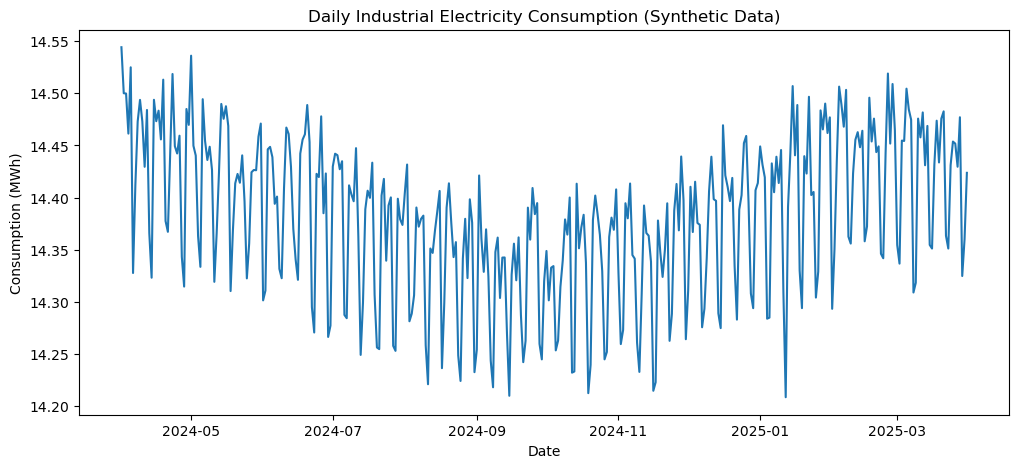

In [78]:
plt.figure(figsize=(12,5))
plt.plot(prophet_df["ds"], prophet_df["y"])
plt.title("Daily Industrial Electricity Consumption (Synthetic Data)")
plt.xlabel("Date")
plt.ylabel("Consumption (MWh)")
plt.show()

### Configure IMPROVED Prophet Model 

We enable:

1> yearly seasonality

2> weekly seasonality

3> changepoint detection

In [79]:
m = Prophet(
    growth="linear",
    seasonality_mode="multiplicative",   # better for energy
    changepoint_prior_scale=0.5,         # smoother trends
    seasonality_prior_scale=10,
    weekly_seasonality=True,
    yearly_seasonality=True
)

# Add monthly seasonality manually
m.add_seasonality(
    name="monthly",
    period=30.5,
    fourier_order=6
)

# Fit the model
m.fit(prophet_df)


21:21:11 - cmdstanpy - INFO - Chain [1] start processing
21:21:11 - cmdstanpy - INFO - Chain [1] done processing


### ✅ ACCURACY EVALUATION BLOCK 

21:21:11 - cmdstanpy - INFO - Chain [1] start processing


Train length: 335  Test length: 30


21:21:11 - cmdstanpy - INFO - Chain [1] done processing



=== Model Accuracy (Last 30 Days) ===
MAE  : 107,332.61
RMSE : 118,550.24
MAPE : 5.87%


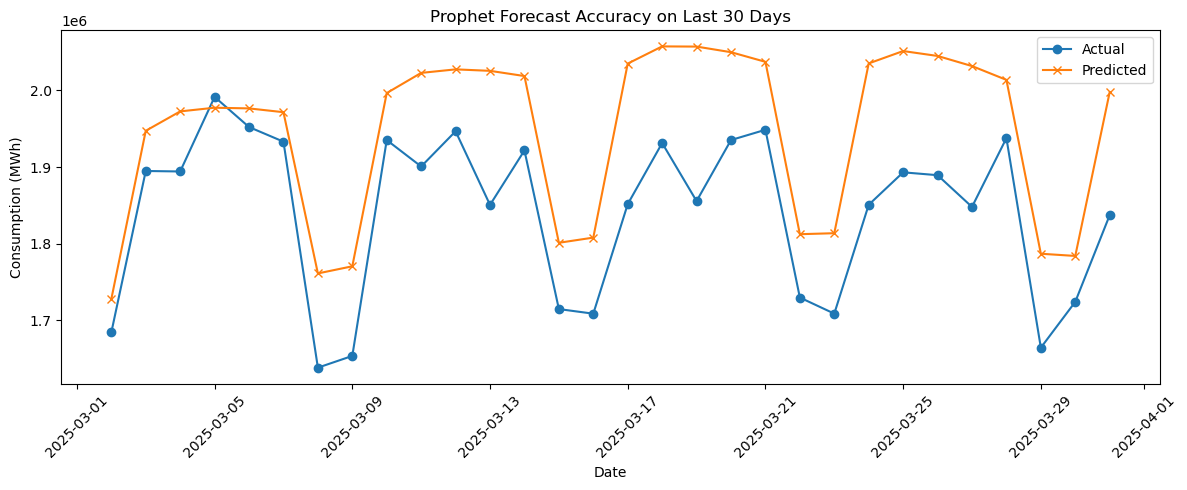

In [80]:
# ============================================================
# 🔍 6. Model Accuracy Evaluation (Train/Test Split)
# ============================================================

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Use LAST 30 DAYS as test set
test_size = 30
train_df = prophet_df.iloc[:-test_size].copy()
test_df  = prophet_df.iloc[-test_size:].copy()

print("Train length:", len(train_df), " Test length:", len(test_df))

# Train a new Prophet model on training data only
m_acc = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='multiplicative'
)
m_acc.fit(train_df)

# Create future (only for test dates)
future_test = test_df[["ds"]].copy()

# Predict on test dates
forecast_test = m_acc.predict(future_test)

# Extract actual vs predicted (inverse log transform)
actual = np.exp(test_df["y"])
predicted = np.exp(forecast_test["yhat"])

# ----------- Metrics ------------

# Clean predicted (handle NaNs and negatives)
predicted = np.where(np.isnan(predicted), np.nanmean(predicted), predicted)
predicted = np.where(predicted < 0, 0, predicted)

mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))

epsilon = 1e-9
mape = np.mean(np.abs((actual - predicted) / (actual + epsilon))) * 100

print("\n=== Model Accuracy (Last 30 Days) ===")
print(f"MAE  : {mae:,.2f}")
print(f"RMSE : {rmse:,.2f}")
print(f"MAPE : {mape:.2f}%")


# ----------- Plot actual vs predicted ------------
plt.figure(figsize=(12,5))
plt.plot(test_df["ds"], actual, label="Actual", marker="o")
plt.plot(test_df["ds"], predicted, label="Predicted", marker="x")
plt.title("Prophet Forecast Accuracy on Last 30 Days")
plt.ylabel("Consumption (MWh)")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


### 🔮 6. Create Future Dates & Forecast

In [81]:
future = m.make_future_dataframe(periods=730)  # 2 years

forecast = m.predict(future)

# Reverse log-transform if applied
forecast["yhat"] = np.exp(forecast["yhat"])



### 📊 7. Plot Forecast 

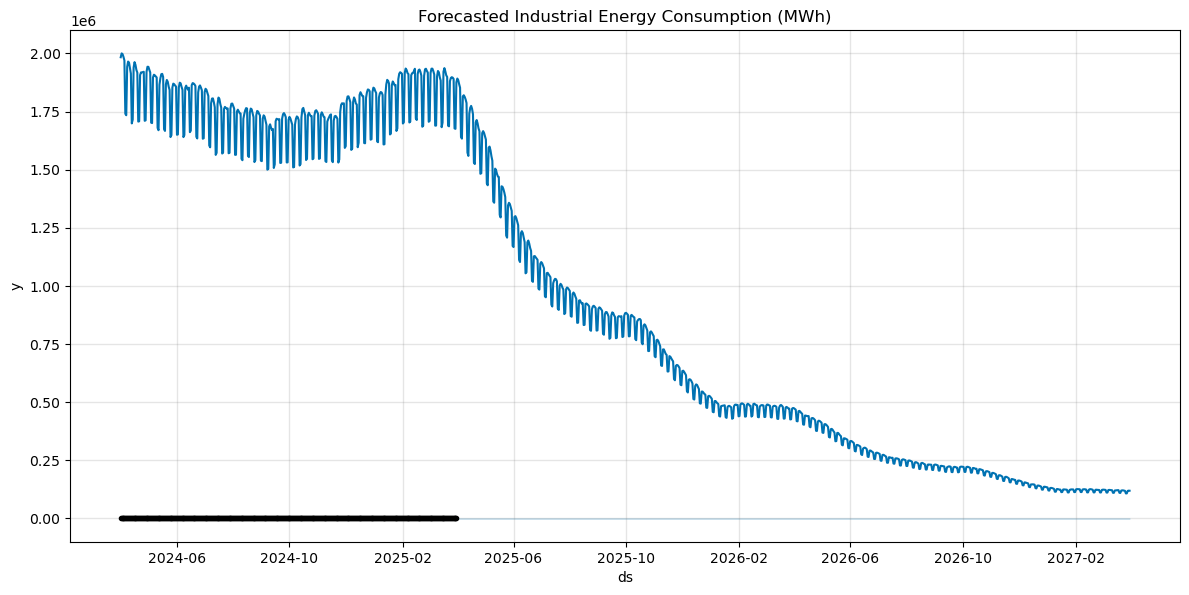

In [82]:
m.plot(forecast, figsize=(12,6))
plt.title("Forecasted Industrial Energy Consumption (MWh)")
plt.show()


### Plot Forecast Components

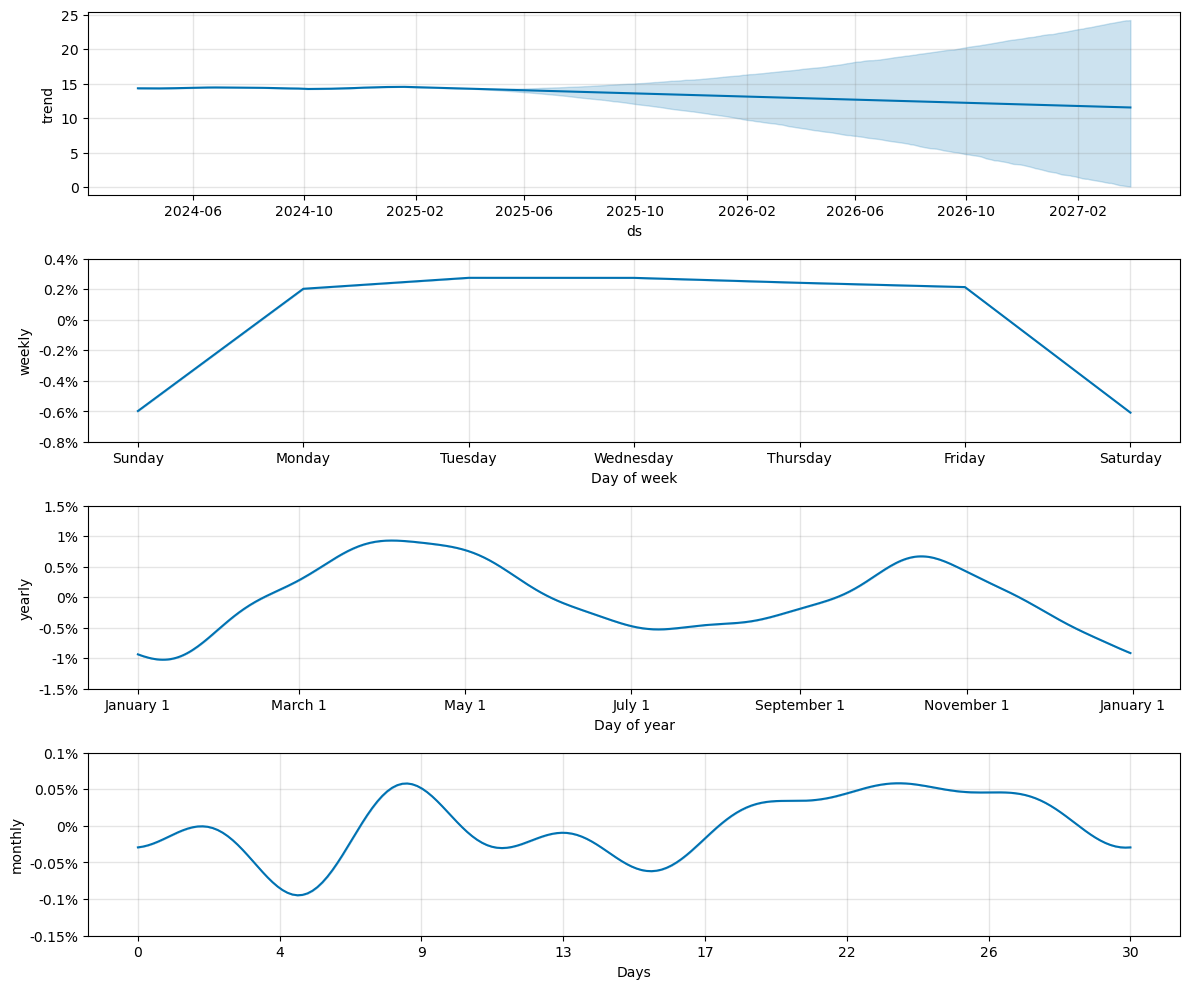

In [83]:
m.plot_components(forecast, figsize=(12,10))
plt.show()


### Compare with MoSPI Annual Totals 

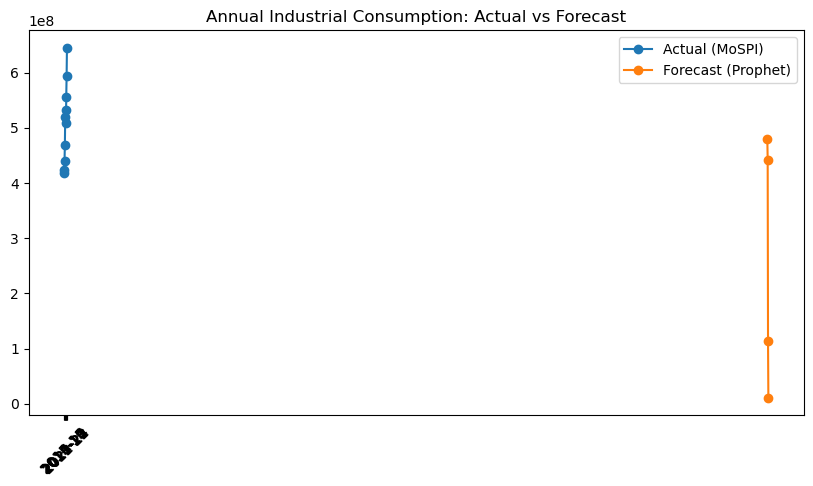

In [84]:
# Compute annual totals from forecast
forecast_yearly = (
    forecast.assign(year=forecast["ds"].dt.year)
            .groupby("year", as_index=False)["yhat"].sum()
            .rename(columns={"yhat": "forecast_mwh"})
)

# Prepare actual MoSPI data
annual_actual = annual_df.copy()
annual_actual["industry_mwh"] = annual_actual["industry_gwh"] * 1000

plt.figure(figsize=(10,5))
plt.plot(annual_actual["year"], annual_actual["industry_mwh"], marker="o", label="Actual (MoSPI)")
plt.plot(forecast_yearly["year"], forecast_yearly["forecast_mwh"], marker="o", label="Forecast (Prophet)")
plt.title("Annual Industrial Consumption: Actual vs Forecast")
plt.xticks(rotation=45)
plt.legend()
plt.show()


### Load hourly data + build diurnal profile

In [85]:
import os

# Try processed path first, then notebooks fallback
hourly_candidates = [
    "../data/processed/industry_hourly_synthetic.csv",
    "./industry_hourly_synthetic.csv",             # notebooks folder fallback
    "../notebooks/industry_hourly_synthetic.csv"   # another common fallback
]

hourly_path = None
for p in hourly_candidates:
    if os.path.exists(p):
        hourly_path = p
        break

if hourly_path is None:
    raise FileNotFoundError("Couldn't find industry_hourly_synthetic.csv in expected locations.")

hourly_df = pd.read_csv(hourly_path, parse_dates=["datetime"])
hourly_df = hourly_df.sort_values("datetime")

# Ensure units align with your scaled daily_df: rescale hourly with the SAME factor
# (recompute factor from already-scaled daily_df so we match precisely)
daily_sum_after = daily_df["industry_consumption_mwh"].sum()
hourly_sum_before = hourly_df["industry_consumption_mwh"].sum()
factor = daily_sum_after / hourly_sum_before
hourly_df["industry_consumption_mwh"] *= factor

print("Hourly file:", hourly_path)
print("Hourly rows:", len(hourly_df))
print("Hourly sum AFTER scaling = ", hourly_df["industry_consumption_mwh"].sum())

# --- Build average diurnal profile (24-hour shape) from the synthetic hourly ---
hourly_df["date"] = hourly_df["datetime"].dt.date
hourly_df["hour"] = hourly_df["datetime"].dt.hour
hourly_df["dow"] = hourly_df["datetime"].dt.dayofweek  # 0=Mon

# Weekday/weekend aware profile (useful for peak prediction)
avg_hour_by_dow = (
    hourly_df.groupby(["dow","hour"])["industry_consumption_mwh"]
             .mean()
             .reset_index()
)

# Also keep a simple overall 24h profile as fallback
avg_hour_24 = (
    hourly_df.groupby("hour")["industry_consumption_mwh"]
             .mean()
             .reset_index()
)
avg_hour_24["w"] = avg_hour_24["industry_consumption_mwh"] / avg_hour_24["industry_consumption_mwh"].sum()
avg_hour_24 = avg_hour_24[["hour","w"]]


Hourly file: ../data/processed/industry_hourly_synthetic.csv
Hourly rows: 8760
Hourly sum AFTER scaling =  644999999.9999999


### Visuals: heatmap of hourly shape

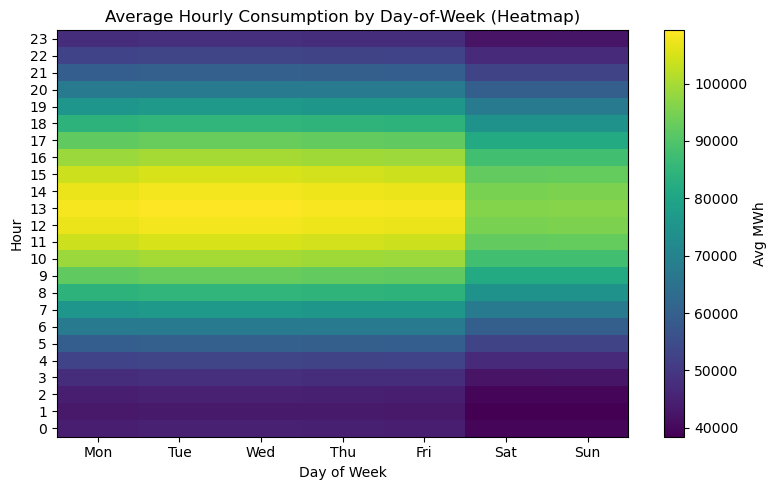

In [86]:
import numpy as np
import matplotlib.pyplot as plt

# Pivot to [hour x day-of-week] matrix
mat = avg_hour_by_dow.pivot(index="hour", columns="dow", values="industry_consumption_mwh").values

plt.figure(figsize=(8,5))
plt.imshow(mat, aspect="auto", origin="lower")
plt.colorbar(label="Avg MWh")
plt.xticks(ticks=range(7), labels=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
plt.yticks(ticks=range(24), labels=range(24))
plt.title("Average Hourly Consumption by Day-of-Week (Heatmap)")
plt.xlabel("Day of Week")
plt.ylabel("Hour")
plt.tight_layout()
plt.show()


### Peak load (historical) & top peak days 

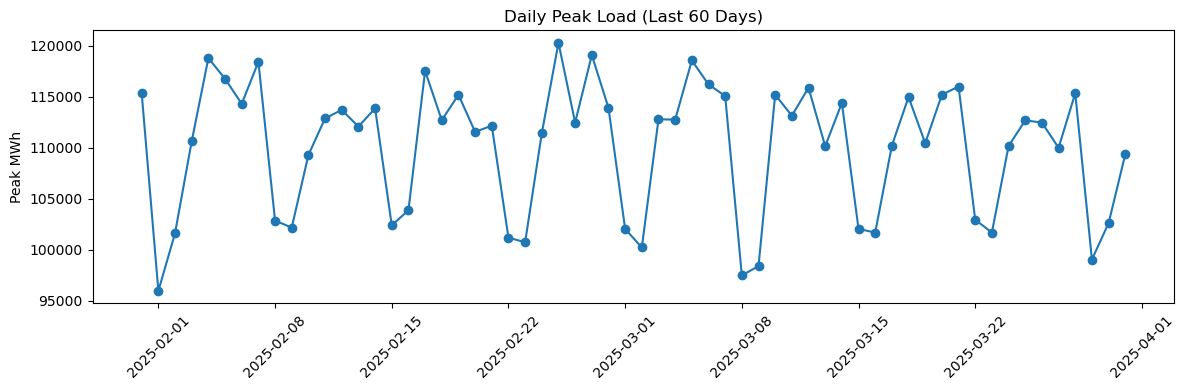

Top 10 peak days:
            date       peak_mwh  peak_hour
0    2024-04-01  123354.335477         13
30   2024-05-01  122357.484232         13
4    2024-04-05  121001.008731         13
330  2025-02-25  120281.115198         13
22   2024-04-23  120226.586418         13
18   2024-04-19  119574.633486         13
332  2025-02-27  119078.442782         13
289  2025-01-15  118841.205416         13
309  2025-02-04  118778.682147         13
338  2025-03-05  118546.080680         13


In [87]:
# Daily peak and corresponding hour
daily_peaks = (
    hourly_df.groupby("date")
             .agg(peak_mwh=("industry_consumption_mwh", "max"))
             .reset_index()
)

# Find the hour of the peak for each day
idx = hourly_df.groupby("date")["industry_consumption_mwh"].idxmax()
peak_hours = hourly_df.loc[idx, ["date","hour"]].rename(columns={"hour":"peak_hour"})
daily_peaks = daily_peaks.merge(peak_hours, on="date")

# Plot last 60 days of daily peak
recent = daily_peaks.sort_values("date").tail(60)
plt.figure(figsize=(12,4))
plt.plot(recent["date"], recent["peak_mwh"], marker="o")
plt.title("Daily Peak Load (Last 60 Days)")
plt.ylabel("Peak MWh")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Top 10 peak days
top10 = daily_peaks.sort_values("peak_mwh", ascending=False).head(10)
print("Top 10 peak days:\n", top10)


### Forecast hourly from daily forecast (using diurnal profile) 

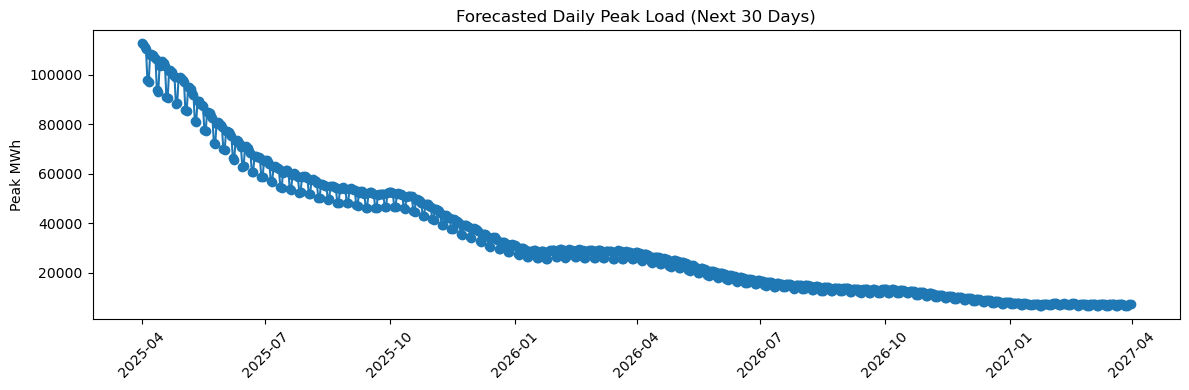

Saved: forecast_daily_peaks_next30.csv, hourly_forecast_allocated.csv


In [88]:
# Take future section of forecast (the dates beyond training end)
train_last_date = prophet_df["ds"].max().date()
future_daily = forecast[forecast["ds"].dt.date > train_last_date][["ds","yhat"]].copy()

# Build hourly timestamps for each forecast day using 24h weights
rows = []
for _, r in future_daily.iterrows():
    d = r["ds"].date()
    total = r["yhat"]  # daily MWh forecast
    for h, w in avg_hour_24.itertuples(index=False):
        rows.append({
            "datetime": pd.Timestamp(d) + pd.Timedelta(hours=int(h)),
            "mwh": total * w
        })

hourly_forecast = pd.DataFrame(rows).sort_values("datetime")

# Extract forecast daily peaks
hourly_forecast["date"] = hourly_forecast["datetime"].dt.date
hourly_forecast["hour"] = hourly_forecast["datetime"].dt.hour

future_peaks = (
    hourly_forecast.groupby("date")
                   .agg(peak_mwh=("mwh","max"))
                   .reset_index()
)
idx2 = hourly_forecast.groupby("date")["mwh"].idxmax()
future_peak_hours = hourly_forecast.loc[idx2, ["date","hour"]].rename(columns={"hour":"peak_hour"})
future_peaks = future_peaks.merge(future_peak_hours, on="date")

# Visualize next 30 days of peak forecast
plt.figure(figsize=(12,4))
plt.plot(future_peaks["date"], future_peaks["peak_mwh"], marker="o")
plt.title("Forecasted Daily Peak Load (Next 30 Days)")
plt.ylabel("Peak MWh")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save for the app
os.makedirs("../models", exist_ok=True)
future_peaks.to_csv("../models/forecast_daily_peaks_next30.csv", index=False)
hourly_forecast.to_csv("../models/hourly_forecast_allocated.csv", index=False)
print("Saved: forecast_daily_peaks_next30.csv, hourly_forecast_allocated.csv")


### Anomaly detection (IsolationForest) on daily totals

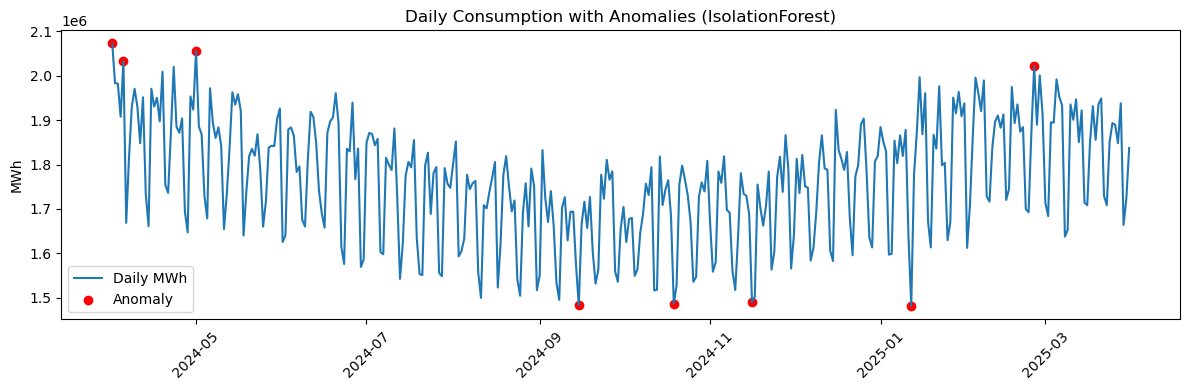

Saved: daily_totals_with_anomaly_scores.csv, daily_anomalies.csv


In [89]:
from sklearn.ensemble import IsolationForest

# Build daily totals from scaled hourly series (robust)
daily_totals = (
    hourly_df.groupby("date")["industry_consumption_mwh"]
             .sum()
             .reset_index()
             .rename(columns={"industry_consumption_mwh":"mwh"})
)

# Fit IsolationForest (tune contamination to how many anomalies you expect)
iso = IsolationForest(n_estimators=300, contamination=0.02, random_state=42)
daily_totals["score"] = iso.fit_predict(daily_totals[["mwh"]])
daily_totals["anomaly"] = daily_totals["score"].map({1:0, -1:1})

# Visualize with anomalies highlighted
plt.figure(figsize=(12,4))
plt.plot(daily_totals["date"], daily_totals["mwh"], label="Daily MWh")
plt.scatter(daily_totals.loc[daily_totals["anomaly"]==1, "date"],
            daily_totals.loc[daily_totals["anomaly"]==1, "mwh"],
            color="red", label="Anomaly")
plt.title("Daily Consumption with Anomalies (IsolationForest)")
plt.ylabel("MWh")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Export anomalies table
anoms = daily_totals[daily_totals["anomaly"]==1].copy()
os.makedirs("../models", exist_ok=True)
daily_totals.to_csv("../models/daily_totals_with_anomaly_scores.csv", index=False)
anoms.to_csv("../models/daily_anomalies.csv", index=False)
print("Saved: daily_totals_with_anomaly_scores.csv, daily_anomalies.csv")


### Quick “Optimization Hint” visual (load shifting) 

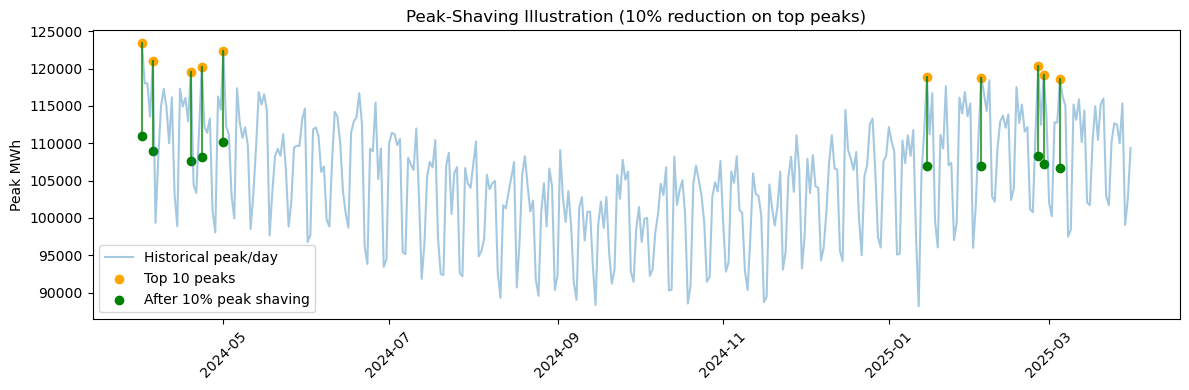

In [90]:
# Take top 10 historical peaks and show a hypothetical 10% peak shaving
top10_hist = daily_peaks.sort_values("peak_mwh", ascending=False).head(10).sort_values("date")

plt.figure(figsize=(12,4))
plt.plot(daily_peaks["date"], daily_peaks["peak_mwh"], alpha=0.4, label="Historical peak/day")
plt.scatter(top10_hist["date"], top10_hist["peak_mwh"], color="orange", label="Top 10 peaks")

# Hypothetical shaving (10%)
plt.scatter(top10_hist["date"], top10_hist["peak_mwh"]*0.9, color="green", label="After 10% peak shaving")
for _, r in top10_hist.iterrows():
    plt.plot([r["date"], r["date"]], [r["peak_mwh"]*0.9, r["peak_mwh"]], color="green", alpha=0.7)

plt.title("Peak-Shaving Illustration (10% reduction on top peaks)")
plt.ylabel("Peak MWh")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


### 📤 8. Save Outputs (Model + Forecast CSV) 

In [91]:
os.makedirs("../models", exist_ok=True)

# Save model
joblib.dump(model, "../models/prophet_industry_model.pkl")
print("Saved model → models/prophet_industry_model.pkl")

# Save forecast
forecast.to_csv("../models/forecast_industry_2024_2030.csv", index=False)
print("Saved forecast → models/forecast_industry_2024_2030.csv")


Saved model → models/prophet_industry_model.pkl
Saved forecast → models/forecast_industry_2024_2030.csv


### 📈 9. Extract Yearly Summary 

In [92]:
forecast["year"] = forecast["ds"].dt.year

annual_forecast = forecast.groupby("year")["yhat"].mean().reset_index()

annual_forecast


,year,yhat
0,2024,1.744736e+06
1,2025,1.212367e+06
2,2026,3.102447e+05
3,2027,1.207337e+05


### 🧩 10. Compare Forecast vs Historical Annual Data

Columns: ['year', 'industry_gwh', 'total_gwh']


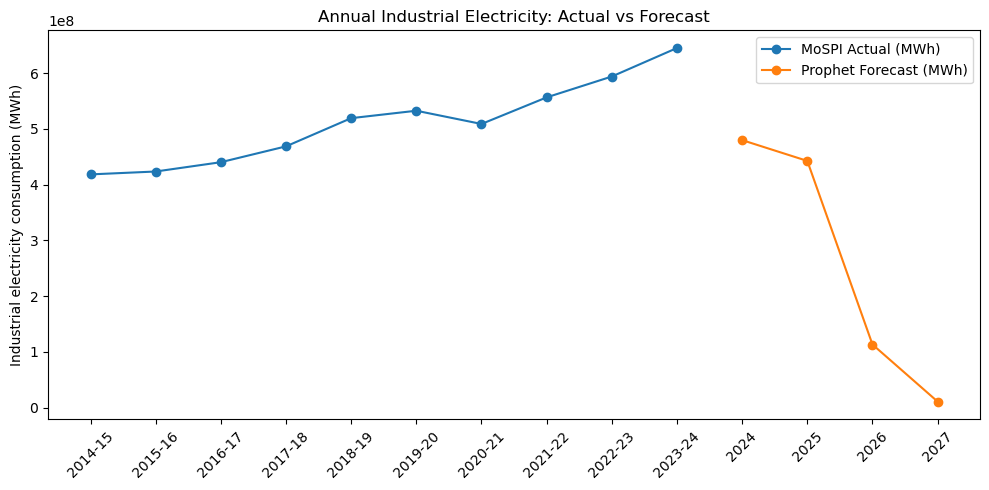

In [93]:
# ---- Load annual MoSPI data and harmonize columns ----
annual_actual_path = "../data/processed/industry_consumption_annual_clean.csv"
annual_actual = pd.read_csv(annual_actual_path)

# Inspect columns quickly (optional)
print("Columns:", list(annual_actual.columns))

# If the file has industry_gwh, convert to MWh
if "industry_consumption_mwh" not in annual_actual.columns:
    if "industry_gwh" in annual_actual.columns:
        annual_actual["industry_consumption_mwh"] = annual_actual["industry_gwh"] * 1000.0
    else:
        raise ValueError("Expected either 'industry_consumption_mwh' or 'industry_gwh' in the annual CSV")

# Clean/standardize year if it looks like '2014-15'
annual_actual["year_label"] = annual_actual["year"].astype(str)

# ---- Aggregate forecast to ANNUAL SUM (MWh) to match MoSPI annual totals ----
forecast_yearly = (
    forecast.assign(year=forecast["ds"].dt.year)
            .groupby("year", as_index=False)["yhat"].sum()
            .rename(columns={"yhat": "forecast_mwh"})
)

# ---- Plot comparison ----
plt.figure(figsize=(10,5))
plt.plot(annual_actual["year_label"], annual_actual["industry_consumption_mwh"], marker="o", label="MoSPI Actual (MWh)")
plt.plot(forecast_yearly["year"].astype(str), forecast_yearly["forecast_mwh"], marker="o", label="Prophet Forecast (MWh)")
plt.xticks(rotation=45)
plt.ylabel("Industrial electricity consumption (MWh)")
plt.title("Annual Industrial Electricity: Actual vs Forecast")
plt.legend()
plt.tight_layout()
plt.show()
